# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импортируем библиотеки и просмотрим датасет

In [1]:
!pip install shap

     |████████████████████████████████| 572 kB 1.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Проверим данные на явные дубликаты и удалим их

In [7]:
data.duplicated().sum()

4

In [8]:
duplicates = data.duplicated(keep=False)
duplicate_rows = data[duplicates]
duplicate_rows

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [9]:
data.drop_duplicates(inplace=True)

Проверим данные на пропуски

In [10]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Скорее всего пропущенные значения в столбце ремонт говорят о том, что машина ремонту не подлежала, заменим пропуски на 'no'

In [11]:
data['Repaired'] = data['Repaired'].fillna('no')

In [12]:
# Замена пропущенных значений в 'VehicleType' модой с группировкой
data['VehicleType'] = data.groupby(['Model', 'RegistrationYear'])['VehicleType'].apply(lambda x: x.fillna(x.mode().iat[0]) if x.notnull().any() else x)

# Замена пропущенных значений в 'FuelType' модой с группировкой
data['FuelType'] = data.groupby(['Model', 'RegistrationYear'])['FuelType'].apply(lambda x: x.fillna(x.mode().iat[0]) if x.notnull().any() else x)

# Замена пропущенных значений в 'Gearbox' модой с группировкой
data['Gearbox'] = data.groupby(['Model', 'RegistrationYear'])['Gearbox'].apply(lambda x: x.fillna(x.mode().iat[0]) if x.notnull().any() else x)

# Замена пропущенных значений в 'Model' модой с группировкой
data['Model'] = data.groupby(['Brand', 'RegistrationYear', 'Power'])['Model'].apply(lambda x: x.fillna(x.mode().iat[0]) if x.notnull().any() else x)


Избавимся от ненужных для машинного обучения столбцов

In [13]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)


* Количество фотографий, почтовый индекс и последний раз, когда пользователь был онлайн, не имеют прямого влияния на цену. 
* Месяц регистрации автомобиля может говорить о некой сезонности продаж, но так же может ухудшить качество предсказаний модели. 
* Даты создания и скачивания анкет могут говорить о том, что некоторые автомобили простаиваются, вероятнее всего из-за завышенной цены отностельно рынка. 
* Для обучения модели эти признаки не особо важны. 

In [14]:
data.isna().sum()

Price                   0
VehicleType         32268
RegistrationYear        0
Gearbox             19958
Power                   0
Model                4643
Kilometer               0
FuelType            20036
Brand                   0
Repaired                0
dtype: int64

Количество пропусков уменьшилось, заполним оставшиеся

In [15]:
data['VehicleType'].fillna(data['VehicleType'].mode().iat[0], inplace=True)
data['FuelType'].fillna(data['FuelType'].mode().iat[0], inplace=True)
data['Gearbox'].fillna(data['Gearbox'].mode().iat[0], inplace=True)
data['Model'].fillna(data['Model'].mode().iat[0], inplace=True)

In [16]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [17]:
data['RegistrationYear'].value_counts()

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 151, dtype: int64

Ограними значения дат регистрации, уберём выбросы

In [18]:
lowest_year = data['RegistrationYear'].quantile(0.001)
lowest_year

1957.0

In [19]:
highest_year = data['RegistrationYear'].quantile(0.98)
highest_year

2017.0

In [20]:
def registration(data):
    data = data.loc[(data['RegistrationYear'] < highest_year) & (data['RegistrationYear'] > lowest_year)]
    return data

In [21]:
data = registration(data)

In [22]:
data['Power'].value_counts()

0        36277
75       22803
60       15164
150      14148
101      12732
         ...  
671          1
15001        1
1360         1
6226         1
1548         1
Name: Power, Length: 699, dtype: int64

ограничим мощность автомобилей 1000 л.с.

In [23]:
data = data[(data['Power'] < 1000) & (data['Power'] > 0)]

In [24]:
data['Power'].value_counts()

75     22803
60     15164
150    14148
101    12732
140    12473
       ...  
525        1
475        1
604        1
960        1
998        1
Name: Power, Length: 483, dtype: int64

In [25]:
data['Price'].value_counts()

0        6397
500      4473
1500     4430
1200     3737
2500     3706
         ... 
19870       1
11410       1
10898       1
3991        1
8188        1
Name: Price, Length: 3592, dtype: int64

Автомобили не могут продаваться за 0 евро, уберём выбросы. 

In [26]:
data = data.loc[data['Price']>0]

Преобразуем данные по ремонту в числовые

In [27]:
data['Repaired'] = data['Repaired'].replace({'yes': 1, 'no': 0}).astype('int64')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296516 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             296516 non-null  int64 
 1   VehicleType       296516 non-null  object
 2   RegistrationYear  296516 non-null  int64 
 3   Gearbox           296516 non-null  object
 4   Power             296516 non-null  int64 
 5   Model             296516 non-null  object
 6   Kilometer         296516 non-null  int64 
 7   FuelType          296516 non-null  object
 8   Brand             296516 non-null  object
 9   Repaired          296516 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 24.9+ MB


Поменяем тип данных на категориальные

In [29]:
def changing_type(data,categorical_columns):
    data[categorical_columns] = data[categorical_columns].astype('category')
    return data

categorical_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
numeric_columns = ['Power', 'Kilometer', 'RegistrationYear']

In [30]:
data = changing_type(data, categorical_columns)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296516 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             296516 non-null  int64   
 1   VehicleType       296516 non-null  category
 2   RegistrationYear  296516 non-null  int64   
 3   Gearbox           296516 non-null  category
 4   Power             296516 non-null  int64   
 5   Model             296516 non-null  category
 6   Kilometer         296516 non-null  int64   
 7   FuelType          296516 non-null  category
 8   Brand             296516 non-null  category
 9   Repaired          296516 non-null  int64   
dtypes: category(5), int64(5)
memory usage: 15.3 MB


In [32]:
categorical_columns = np.array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'])
categorical_columns

array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'],
      dtype='<U11')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296516 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             296516 non-null  int64   
 1   VehicleType       296516 non-null  category
 2   RegistrationYear  296516 non-null  int64   
 3   Gearbox           296516 non-null  category
 4   Power             296516 non-null  int64   
 5   Model             296516 non-null  category
 6   Kilometer         296516 non-null  int64   
 7   FuelType          296516 non-null  category
 8   Brand             296516 non-null  category
 9   Repaired          296516 non-null  int64   
dtypes: category(5), int64(5)
memory usage: 15.3 MB


# Вывод:
* Предобработка данных выполнена
* Данные проверены на дубликаты
* Пропущенные значения заполнены модой
* Удалены признаки, напрямую не влияющие на ценообразование автомобилей
* Преобразованы категориальные признаки
* Удалены выбросы

## Обучение моделей

Отделим целевой признак и обучащие

In [34]:
features = data.drop('Price', axis=1)
target = data['Price']

In [35]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, 
                                                                             random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, 
                                                                            test_size=0.5, random_state=12345)

Стандартизируем обучающие признаки

In [36]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

Создадим список для дальнейшего анализа

In [37]:
models_scores = pd.DataFrame(columns = ['Model', 'RMSE', 'Training Time', 'Prediction Time'])

Сравним 3 модели по RMSE, времени обучения и времени предсказаний:
* LinearRegression
* CatBoostRegressor
* LightGBMRegressor

Закодируем категориальные признаки для вычисления cross_val_csore и обучения модели Линейной Регрессии

In [38]:
# Кодирование категориальных признаков
encoder = OrdinalEncoder()
encoder.fit(features_train[categorical_columns])
features_encoded = features.copy()
features_train_encoded = features_train.copy()
features_valid_encoded = features_valid.copy()
features_test_encoded = features_test.copy()
features_encoded[categorical_columns] = encoder.transform(features[categorical_columns])
features_train_encoded[categorical_columns] = encoder.transform(features_train[categorical_columns])
features_valid_encoded[categorical_columns] = encoder.transform(features_valid[categorical_columns])
features_test_encoded[categorical_columns] = encoder.transform(features_test[categorical_columns])


In [39]:
# Создание экземпляра класса OneHotEncoder
encoder = OneHotEncoder(categories='auto', sparse=False, drop='first')

# Применение кодирования категориальных признаков на тренировочном наборе
ohe_features_train = encoder.fit_transform(features_train[categorical_columns])

# Применение кодирования категориальных признаков на валидационном наборе
ohe_features_valid = encoder.transform(features_valid[categorical_columns])

# Применение кодирования категориальных признаков на тестовом наборе
ohe_features_test = encoder.transform(features_test[categorical_columns])

# Объединение закодированных категориальных признаков с числовыми признаками
features_train_ohe = np.concatenate([ohe_features_train, features_train[numeric_columns]], axis=1)
features_valid_ohe = np.concatenate([ohe_features_valid, features_valid[numeric_columns]], axis=1)
features_test_ohe = np.concatenate([ohe_features_test, features_test[numeric_columns]], axis=1)


In [40]:
model = LinearRegression()

# Вычисление RMSE на кросс-валидации
scores = np.sqrt(-cross_val_score(model, features_train_ohe, target_train, cv=5, 
                                  scoring='neg_mean_squared_error'))
mean_rmse = np.mean(scores)

print('Средний RMSE на кросс-валидации:', mean_rmse)

Средний RMSE на кросс-валидации: 2686.3994032643545


In [41]:
%%time

start_time = time.time()

model = LinearRegression()
model.fit(features_train_ohe, target_train)

training_time = time.time() - start_time
start_time = time.time()

predictions = model.predict(features_valid_ohe)
prediction_time = time.time() - start_time

rmse = mean_squared_error(target_valid, predictions, squared=False)
print('Training Time:', training_time)
print('Prediction Time:', prediction_time)
print('RMSE:', rmse)

models_scores = models_scores.append({'Model': 'Linear Regression', 'RMSE': rmse,
                    'Training Time': training_time, 'Prediction Time': prediction_time}, 
                                     ignore_index=True)

Training Time: 15.707596063613892
Prediction Time: 0.10525822639465332
RMSE: 2654.7431388690707
CPU times: user 11.5 s, sys: 4.41 s, total: 15.9 s
Wall time: 15.9 s


In [42]:
%%time
# Создание модели CatBoostRegressor
model = CatBoostRegressor(verbose=False)

# Задание сетки параметров для подбора
param_grid = {
    'iterations': np.arange(50, 101, 50),
    'depth': np.arange(6, 10, 3),
    'learning_rate': [0.1, 0.3]
}

# Создание объекта RandomizedSearchCV для подбора гиперпараметров
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, 
                                   scoring='neg_mean_squared_error', n_iter=6, n_jobs=-1)

# Подгонка модели на данных с использованием кросс-валидации и подбора гиперпараметров
random_search.fit(features_train, target_train, cat_features=categorical_columns)

# Оценка производительности модели на валидационном наборе
predictions_valid = random_search.best_estimator_.predict(features_valid)
rmse_valid = np.sqrt(mean_squared_error(target_valid, predictions_valid))

# Обучение модели на тренировочных данных и замер времени
start_time = time.time()
random_search.best_estimator_.fit(features_train, target_train, cat_features=categorical_columns)
training_time = time.time() - start_time

# Предсказание на валидационном наборе и замер времени
start_time = time.time()
predictions_valid = random_search.best_estimator_.predict(features_valid)
prediction_time = time.time() - start_time

# Вычисление RMSE модели на валидационном наборе
rmse_valid = np.sqrt(mean_squared_error(target_valid, predictions_valid))

# Вывод результатов
print('Лучшие гиперпараметры:', random_search.best_params_)
print('RMSE модели на валидационном наборе:', rmse_valid)
print('Время обучения:', training_time)
print('Время предсказания:', prediction_time)


Лучшие гиперпараметры: {'learning_rate': 0.3, 'iterations': 100, 'depth': 9}
RMSE модели на валидационном наборе: 1624.532639016589
Время обучения: 8.358935832977295
Время предсказания: 0.04324817657470703
CPU times: user 1min 14s, sys: 1.1 s, total: 1min 15s
Wall time: 1min 31s


In [43]:
%%time
start_time = time.time()

model = CatBoostRegressor(loss_function='RMSE', iterations=100, depth=9, learning_rate=0.3, 
                          thread_count=-1)
model.fit(features_train, target_train, cat_features=categorical_columns, verbose=50)

training_time = time.time() - start_time
start_time = time.time()

predictions = model.predict(features_valid)
prediction_time = time.time() - start_time

rmse = mean_squared_error(target_valid, predictions, squared=False)
print('Training Time:', training_time)
print('Prediction Time:', prediction_time)
print('RMSE:', rmse)

models_scores = models_scores.append({'Model': 'CatBoostRegressor', 'RMSE': rmse,
                    'Training Time': training_time, 'Prediction Time': prediction_time}, 
                                     ignore_index=True)

0:	learn: 3684.2046657	total: 80.4ms	remaining: 7.96s
50:	learn: 1622.0486479	total: 3.68s	remaining: 3.54s
99:	learn: 1545.6132491	total: 7s	remaining: 0us
Training Time: 7.964730739593506
Prediction Time: 0.04388260841369629
RMSE: 1624.532639016589
CPU times: user 6.96 s, sys: 83.1 ms, total: 7.04 s
Wall time: 8.01 s


Подбор гиперпараметров для модели LGBMRegressor занимает очень много времени, поэтому я подобрал гиперпараметры эмпирическим путём  

In [44]:
%%time
start_time = time.time()

model = LGBMRegressor(boosting_type='gbdt', num_leaves=31, learning_rate=0.3, 
                      n_estimators=50, n_jobs=-1)
model.fit(features_train, target_train)

training_time = time.time() - start_time
start_time = time.time()

predictions = model.predict(features_valid)
prediction_time = time.time() - start_time

rmse = mean_squared_error(target_valid, predictions, squared=False)
print('Training Time:', training_time)
print('Prediction Time:', prediction_time)
print('RMSE:', rmse)

models_scores = models_scores.append({'Model': 'LGBMRegressor', 'RMSE': rmse,
                    'Training Time': training_time, 'Prediction Time': prediction_time}, 
                                     ignore_index=True)


Training Time: 2.8837180137634277
Prediction Time: 0.2084970474243164
RMSE: 1617.778672543513
CPU times: user 3.17 s, sys: 0 ns, total: 3.17 s
Wall time: 3.1 s


# Вывод:
* Целевой признак и обучающие разделены
* Разделены обучающая, валидационная и тестовая выборки в соотношении 3:1:1
* Стандартизированы обучающие признаки
* Обучены 3 модели: LinearRegression, LightGBMRegressor, CatBosstRegressor
* К модели CatBosstRegressor подобраны гиперпараметры методом RandomizedSearchCV
* К модели LightGBMRegressor гиперпараметры подобраны эмпирическим путём из-за слишком большого количества времени подбора методом RandomizedSearchCV

## Анализ моделей

In [45]:
models_scores

,Model,RMSE,Training Time,Prediction Time
0,Linear Regression,2654.743139,15.707596,0.105258
1,CatBoostRegressor,1624.532639,7.964731,0.043883
2,LGBMRegressor,1617.778673,2.883718,0.208497


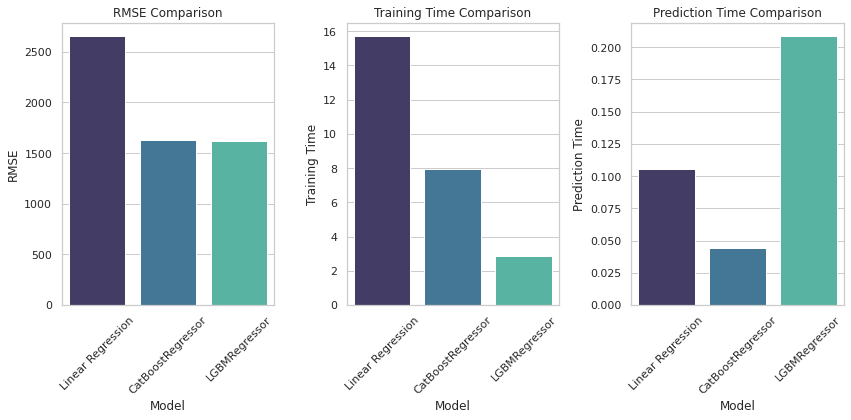

In [46]:
# Создание графика
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

# Построение графика RMSE
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='RMSE', data=models_scores, palette='mako')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

# Поворот меток по оси X для лучшей читаемости
plt.xticks(rotation=45)

# Построение графика времени обучения
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='Training Time', data=models_scores, palette='mako')
plt.title('Training Time Comparison')
plt.ylabel('Training Time')
plt.xticks(rotation=45)

# Построение графика времени предсказания
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='Prediction Time', data=models_scores, palette='mako')
plt.title('Prediction Time Comparison')
plt.ylabel('Prediction Time')
plt.xticks(rotation=45)

# Отображение графика
plt.tight_layout()
plt.show()

# Вывод:
* Простая модель, LinearRegressor, имеет слишком высокий показатель RMSE (2654), так что не подходит для решения нашей задачи;
* Моделям CatBoostRegressor и LGBTRegressor удалось достичь RMSE менее 2500;
* По времени обучения CatBoostRegressor значительно (на 30 секунд) превосходит LGBMRegressor;
* По времени предсказаний CatBoostRegressor также превосходит LGBTRegressor;
* У модели CatBoostRegressor показатель RMSE = 1624, у LGBTRegressor RMSE = 1617;
* По  показателю RMSE LGBTRegressor немного превосходит CatBoostRegressor, однако время обучения у CatBoostRegressor намного меньше, поэтому будем использовать её.

Протестируем лучшую модель на выборке test

In [47]:
%%time
start_time = time.time()

model = CatBoostRegressor(loss_function='RMSE', iterations=100, depth=9, learning_rate=0.3, 
                          thread_count=-1)
model.fit(features_train, target_train, cat_features=categorical_columns, verbose=25)

training_time = time.time() - start_time
start_time = time.time()

predictions = model.predict(features_test)
prediction_time = time.time() - start_time

rmse = mean_squared_error(target_test, predictions, squared=False)
print('Training Time:', training_time)
print('Prediction Time:', prediction_time)
print('RMSE:', rmse)

0:	learn: 3684.2046657	total: 72.9ms	remaining: 7.22s
25:	learn: 1717.3995637	total: 1.72s	remaining: 4.9s
50:	learn: 1622.0486479	total: 3.37s	remaining: 3.24s
75:	learn: 1575.8569684	total: 5s	remaining: 1.58s
99:	learn: 1545.6132491	total: 6.64s	remaining: 0us
Training Time: 7.592319011688232
Prediction Time: 0.06499767303466797
RMSE: 1637.806139400135
CPU times: user 6.86 s, sys: 55.9 ms, total: 6.92 s
Wall time: 7.66 s


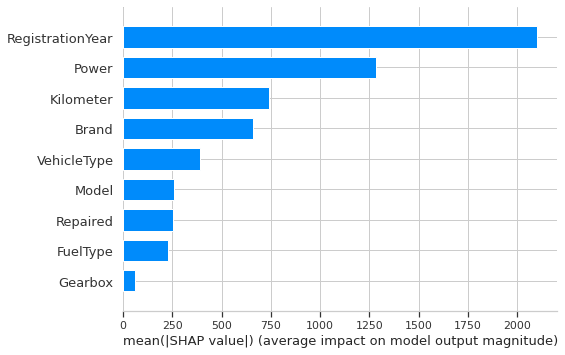

In [48]:
# Инициализация объекта Explainer
explainer = shap.Explainer(model)

# Получение SHAP значений для тестовых данных
shap_values = explainer.shap_values(features_test)

# Визуализация SHAP значений
shap.summary_plot(shap_values, features_test, plot_type='bar')

# Вывод:
* Качество модели CatBoostRegressor соответствует критериям задачи.
* RMSE = 1637
* Время обучения = 8 секунд
* Время предсказаний = 0.05 секунды
* Важнейшими признаками для модели CatBoostRegressor являются:
* Год регистрации автомобиля
* Мощность
* Пробег

# Общий вывод:
* Модель CatBoostRegressor является лучшей для данной задачи;
* Обучение и предсказание Модели CatBoostRegressor не занимает много времени;
* Качество Модели CatBoostRegressor ялвяется практически лучшим среди других моделей;
* Модель CatBoostRegressor прошла проверку качества на тестовой выборке;
* Важнейшими признаками для предсказаний для модели CatBoostRegressor являются: год регистрации автомобиля, мощность и пробег.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей